# ProteinGAN

ProteinGAN is a generative adversarial network adapted to generate functional protein sequences. At its core, it consists of common building blocks: a discriminator and generator, spectral normalization and a loss function based on earth mover's distance etc.

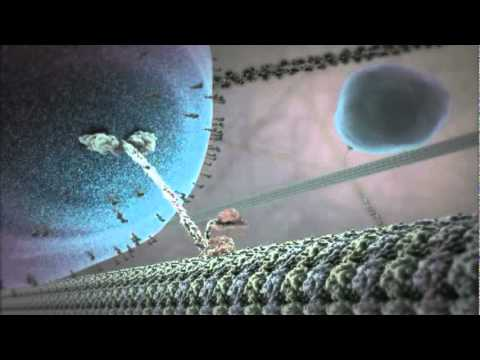

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('wJyUtbn0O5Y', start=75, end=80, autoplay=1, controls=0, loop=1, width=800, height=600)

In [ ]:
# Installing dependencies
! pip install biopython
! pip install py3Dmol
! apt-get install -y clustalo

     |████████████████████████████████| 2.3 MB 5.0 MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libargtable2-0
The following NEW packages will be installed:
  clustalo libargtable2-0
0 upgraded, 2 newly installed, 0 to remove and 37 not upgraded.
Need to get 276 kB of archives.
After this operation, 683 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libargtable2-0 amd64 13-1 [13.6 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 clustalo amd64 1.2.4-1 [263 kB]
Fetched 276 kB in 1s (469 kB/s)
Selecting previously unselected package libargtable2-0.
(Reading database ... 155229 files and directories currently installed.)
Preparing to unpack .../libargtable2-0_13-1_amd64.deb ...
Unpacking libargtable2-0 (13-1) ...
Selecting previously unselected package clustalo.
Preparing to unpack .../clustalo_1.2.4-1_amd64

In [ ]:
# Downloading pre-trained ProteinGAN model
!gdown https://drive.google.com/uc?id=1BfDNgn3Hj2khPfkbjE8azY_yj19igb_n
!unzip pre_trained_protein_gan.zip

Downloading...
From: https://drive.google.com/uc?id=1BfDNgn3Hj2khPfkbjE8azY_yj19igb_n
To: /content/pre_trained_protein_gan.zip
100% 466M/466M [00:03<00:00, 124MB/s]
Archive:  pre_trained_protein_gan.zip
   creating: pre_trained_protein_gan/
  inflating: pre_trained_protein_gan/saved_model.pb  
  inflating: pre_trained_protein_gan/train_rep.fasta  
   creating: pre_trained_protein_gan/variables/
  inflating: pre_trained_protein_gan/variables/variables.data-00000-of-00001  
  inflating: pre_trained_protein_gan/variables/variables.index  


In [4]:
# Helper methods
import shutil

from Bio.Blast import NCBIWWW
from Bio.Blast import NCBIXML

import numpy as np
import pandas as pd

import py3Dmol

# A mapping between amino acids ids and their corresponding letters
ID_TO_AMINO_ACID = {0: '0', 1: 'A', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'K', 10: 'L', 11: 'M', 12: 'N', 13: 'P', 14: 'Q', 15: 'R', 16: 'S', 17: 'T', 18: 'V', 19: 'W', 20: 'Y'}

def to_seqs(model_output):
  """Takes ProteinGAN output and returns list of generated protein sequences"""
  human_readable_seqs = []
  seqs = model_output["prediction"]
  for i in range(len(seqs)):
    human_readable_seq ="".join([ID_TO_AMINO_ACID[a] for a in seqs[i].numpy()])
    human_readable_seq = human_readable_seq.replace("0", "")
    human_readable_seqs.append(human_readable_seq)
  return human_readable_seqs

def get_blast_results(seq):
  """Takes a protein sequence, calls BLAST server and returns parsed results"""
  print("Calling BLAST server. This might take a while")
  r = NCBIWWW.qblast("blastp", "nr", seq, hitlist_size = 5, expect=0.5, 
                     word_size=6, matrix_name="BLOSUM62")
  blast_record = NCBIXML.read(r)

  to_df = []

  for a in blast_record.alignments:
    to_df.append({"name": a.hit_def,"identity": a.hsps[0].identities,
                  "subject": a.hsps[0].sbjct})

  return pd.DataFrame(to_df)

def append_to_fasta(path, seqs, prefix):
  """Appends new sequences to existing file in FASTA format."""
  fasta = ""
  for i, seq in enumerate(seqs):
    fasta += f">{prefix}_{i}\n{seq}\n"
  print(fasta, file=open(path, 'a'))

def interpolate(starting, ending, steps):
  """
  Interpolates between starting and end points. Steps parameter determines 
  how many interpolated points will be returned.
  """
  points = [starting]
  step = (ending-starting)/steps
  for i in range(steps):
    starting = starting + step
    points.append(starting)
  return np.asanyarray(points)

In [5]:
view = py3Dmol.view(query='pdb:1UX1')
view.setStyle({'cartoon':{'color':'spectrum'}})
print("Cytidine deaminase")
view

Cytidine deaminase


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [6]:
np.random.seed(42)
random_seq = "".join(np.random.choice(list(ID_TO_AMINO_ACID.values())[1:], 131))
random_seq

'HYRMIHWMMEIDCNGCANNTLSRRWNYDFWHKHVEQVKCYRHNIRDQTEVIECGLEVNCLEQSRIQISPVRPKRPAHKANIMWTIDDAFLHKHKINCASFDNIDADFRQDAFQHKRRLPWHTYEFHPRMEP'

In [7]:
get_blast_results(random_seq)

Calling BLAST server. This might take a while


""


In [8]:
import tensorflow as tf
tf.random.set_seed(42)
from absl import logging
logging.set_verbosity("ERROR")
tf.get_logger().setLevel("ERROR")

# Loading pre-trained model.
model = tf.saved_model.load("pre_trained_protein_gan/").signatures["serving_default"]

In [11]:
# Choosing random points from latent space.
noise = tf.random.truncated_normal([64, 128], stddev=0.5, dtype=tf.float32)

# Feeding noise to generator to get an output.
model_output = model(noise)

# Model returns indices of amino acids. Here we convert them to actual letters.
seqs = to_seqs(model_output)
seqs[0]

'MDLDELIATARAVMSKAHAPYSNFKVGAAIRTEDGRIHAGCNVENAAYPEGQCAEAGAIAAMIAAGDTRIATITVIGDMEGPITPCGGCRQRIAEFCSAEVPVHMANLHGNTLEMTMAELLPMSFSKEDIDG'

In [12]:
get_blast_results(seqs[0])

Calling BLAST server. This might take a while


,name,identity,subject
0,cytidine deaminase [Maritimibacter sp.],86,LIEDARAVRENAHAPYSGFKVGAAIRTASGRVFTGVNVENAAYPEG...
1,cytidine deaminase [Maritimibacter sp.],83,NSLIEDARAVRENAHAPYSGFKVGAAIRTASGRVFTGVNVENAAYP...
2,cytidine deaminase [Palleronia marisminoris],80,MDDLIAAAATVRENAHAPYSRFKVGAAIRTPDGQVFAGCNVENVAY...
3,cytidine deaminase [Meinhardsimonia xiamenensi...,82,LIDAARAVRDNAHAPYSQFKVGAAIRTASGRVYAGCNVENAAYPEG...
4,cytidine deaminase [Palleronia marisminoris] >...,80,MDDLIAAAATVRENAHAPYSRFKVGAAIRTPDGQVFAGCNVENVAY...


In [13]:
# Generating sequences from points which are close to each other
model_output = model(tf.random.truncated_normal([64, 128], stddev=0.1, dtype=tf.float32))
small_var_seqs = to_seqs(model_output)

# Generating sequences more distrbuted points
model_output = model(tf.random.truncated_normal([64, 128], stddev=1.0, dtype=tf.float32))
large_var_seqs = to_seqs(model_output)

In [14]:
# Creating fasta files which will be used for clustalo to calculate distances
#pre_trained_protein_gan/train_rep.fasta - contains some representative sequences of training dataset
shutil.copy("pre_trained_protein_gan/train_rep.fasta","sequences.fasta")
#Appending generated sequences to training sequences
append_to_fasta("sequences.fasta", small_var_seqs, "small_var")
append_to_fasta("sequences.fasta", large_var_seqs, "large_var")

In [15]:
! clustalo -i sequences.fasta -o fasta.aln --threads=2 -v --full --distmat-out=dist_out.dist --force

Using 2 threads
Read 484 sequences (type: Protein) from sequences.fasta
Calculating pairwise ktuple-distances...
Pairwise distance matrix written to dist_out.dist
Ktuple-distance calculation progress done. CPU time: 7.22u 0.03s 00:00:07.25 Elapsed: 00:00:05
Guide-tree computation done.
Progressive alignment progress done. CPU time: 38.74u 0.80s 00:00:39.54 Elapsed: 00:00:27
Alignment written to fasta.aln


In [16]:
from sklearn.manifold import TSNE

#Loading calculated distances
distance_matrix = pd.read_csv("dist_out.dist", delimiter='\s+', skiprows=[0],header=None,index_col=0)
distance_matrix.columns = distance_matrix.index.values

#Using TSNE to compress all pair wise distances between sequences into two components which then could be plotted.
tsne = TSNE(n_components=2, metric='precomputed')
coordinates_2d = tsne.fit_transform(distance_matrix.values)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


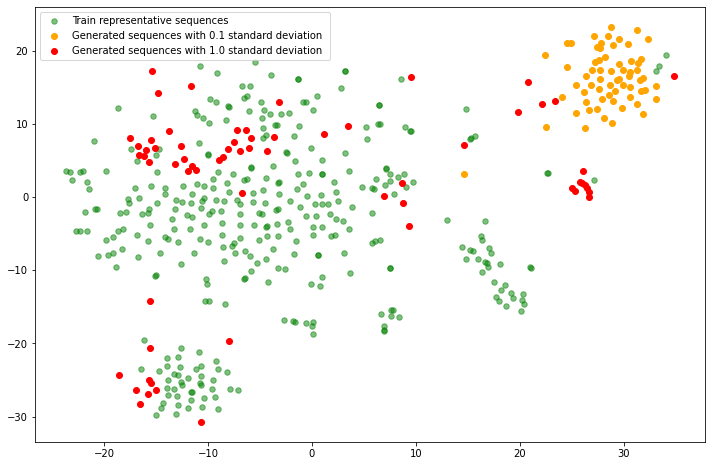

In [17]:
from matplotlib import pyplot as plt


# Plotting train representatives and generated sequences with different diversity
plt.figure(figsize=(12, 8))
plt.scatter(coordinates_2d[:-128,0], coordinates_2d[:-128,1], c="green", label="Train representative sequences", alpha=0.5, s=30)
small_var_el = distance_matrix.index.str.contains("small_var")
plt.scatter(coordinates_2d[small_var_el,0], coordinates_2d[small_var_el,1], c="orange", label="Generated sequences with 0.1 standard deviation")
large_var_el = distance_matrix.index.str.contains("large_var")
plt.scatter(coordinates_2d[large_var_el,0], coordinates_2d[large_var_el,1], c="red", label="Generated sequences with 1.0 standard deviation ")
plt.legend()
plt.show()

In [18]:
from scipy.stats import pearsonr
from Bio.SeqUtils.ProtParam import ProteinAnalysis

# Changing the values of 100th dimension from -1.0 to 1.0
d = 99 
starting = np.zeros([128])
starting[d] = -1.0
ending = np.zeros([128])
ending[d] = 1.0
points = interpolate(starting, ending, 1023)

seqs = []
for i in range(0, 1024, 64):
  model_output = model(tf.constant(points[i:i+64], tf.float32))
  seqs.extend(to_seqs(model_output))

In [19]:
w = [ProteinAnalysis(s).molecular_weight() for s in seqs] 
pearsonr(w, points[:,d])

(0.8172194374483545, 7.726126105655836e-247)

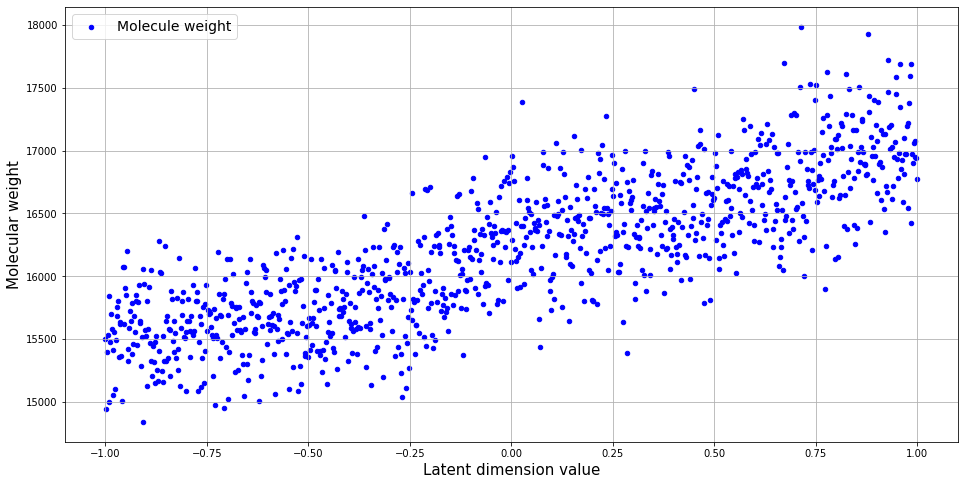

In [20]:
plt.figure(figsize=(16, 8))
plt.scatter(points[:,d], w, c = 'b', s = 20, label = 'Molecule weight')
plt.xlabel("Latent dimension value", fontsize = 15)
plt.ylabel("Molecular weight", fontsize = 15)
plt.legend(fontsize = 14)
plt.grid(True)
plt.show()